# Spaceship Titanic

A notebook trying to predict which Spaceship Titanic passengers were and were not transported into another dimension by the anomaly.

In [1]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import xgboost as xgb

In [2]:
# get the datasets
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')

print(df_train.shape)
print(df_test.shape)

(8693, 14)
(4277, 13)


# Data Exploration

In [3]:
df_train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## First impressions

It looks like both the training and testing set have missing values in a number of columns. I'll have to impute those values or use a method that can handle missing values easily.

I was thinking I wouldn't use PassengerId or Name, but as I look at it I'm thinking I might split out first and last name to see if last names are predictive. Or looking at the Id column, seeing if people who traveled in multiples were more likely.

## Plots

In [6]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

## Histograms for columns

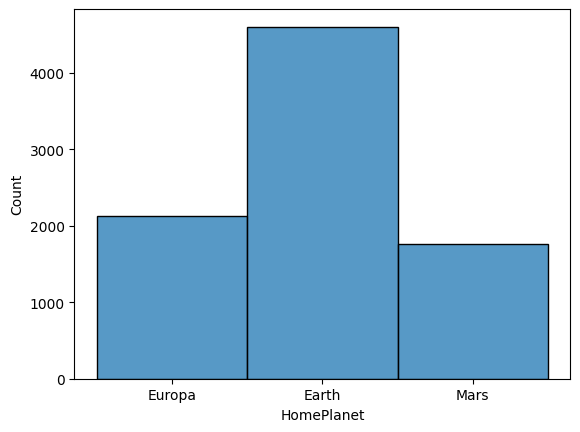

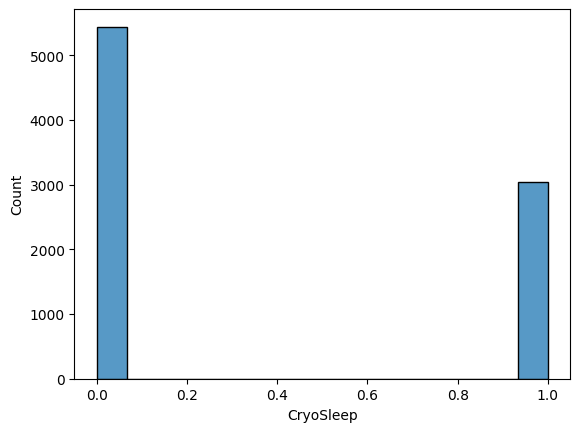

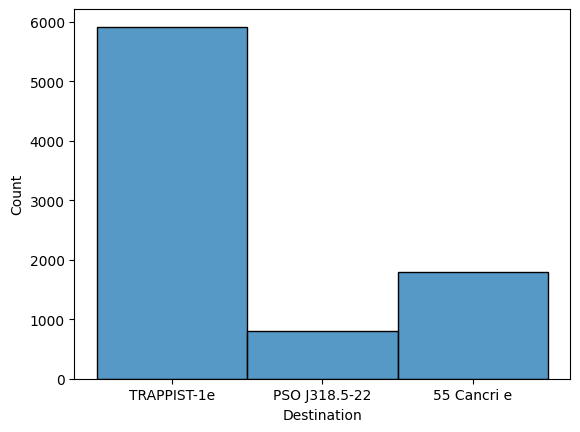

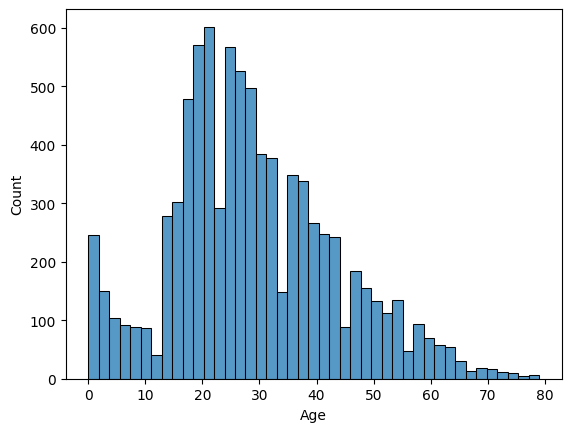

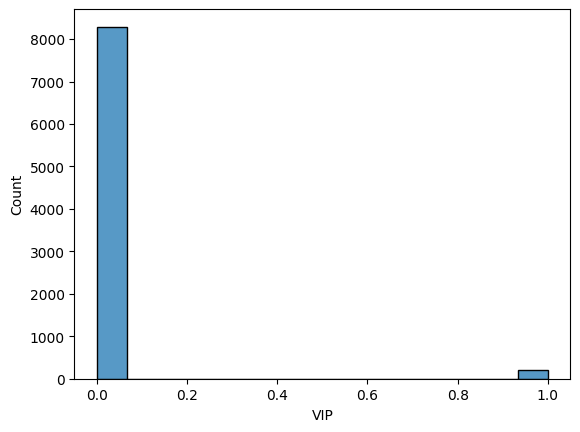

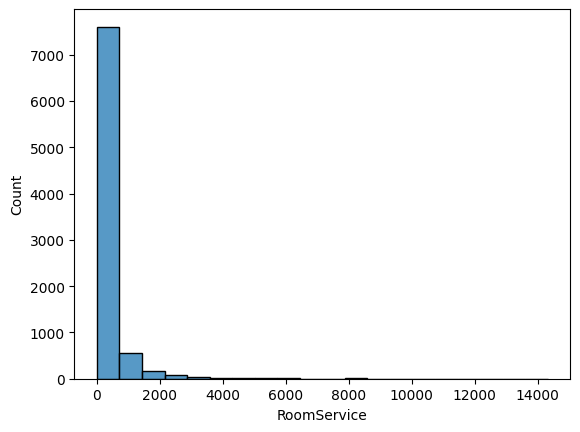

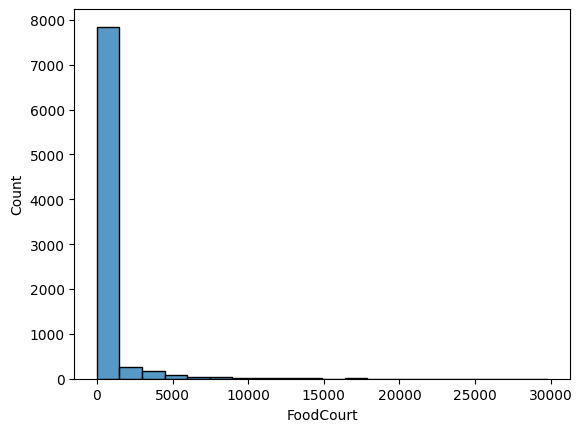

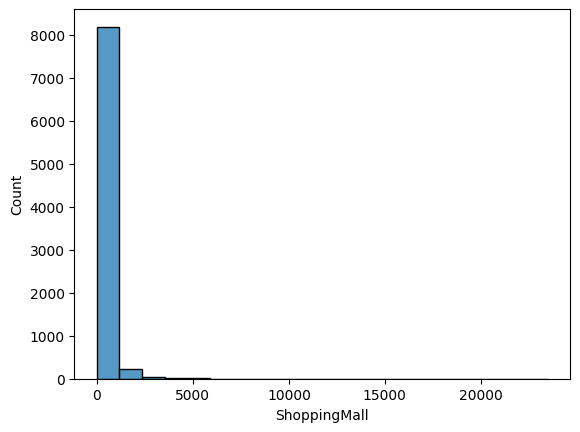

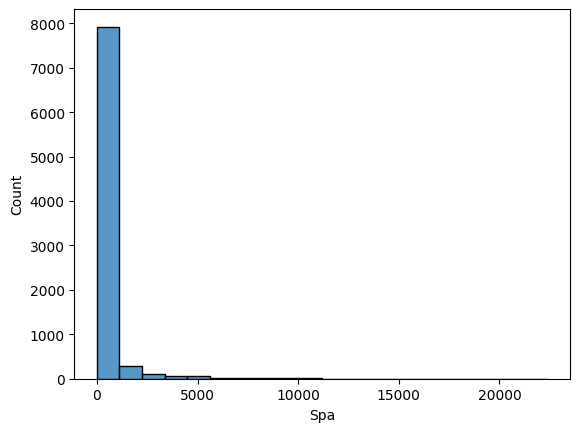

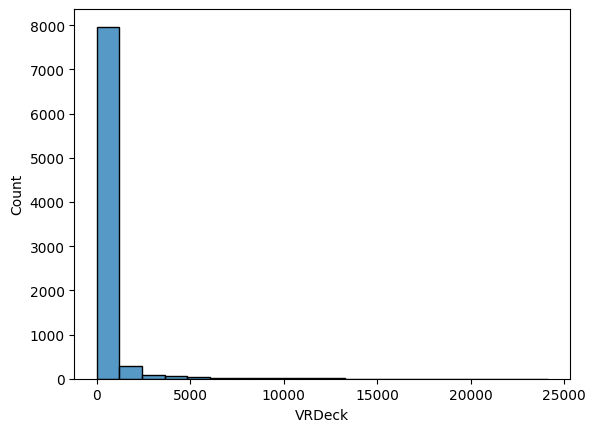

In [7]:
# Plot histograms
for column in ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP']:
    # Histogram plot of the values for each column
    sns.histplot(data=df_train, x=column)
    plt.show()

# These columns have very skewed data that doesn't show up without adjusting bins number
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Histogram plot of the values for each column
    sns.histplot(data=df_train, x=column, bins=20)
    plt.show()

<Axes: >

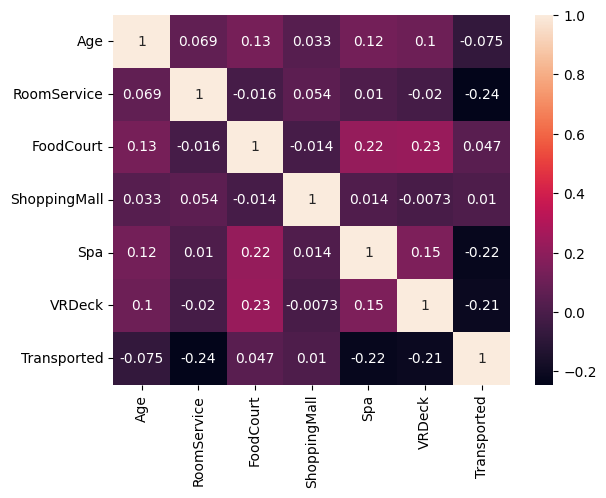

In [8]:
sns.heatmap(df_train.select_dtypes(include=['int', 'float', 'bool']).corr(), annot=True)

From the heatmap, the numeric or boolean values with the most correlation to being transported or not is RoomService, Spa, and VRDeck, which are all negatively correlated. Additionally, none of these variable are tightly correlated to one another.

## Feature Engineering

Ideas for feature engineering:

1. Split cabin on the /s. i.e. B/0/P becomes 3 columns B, 0, and P. Last time I found the first 2 columns have a small number of values and the middle value is largely unique. I'll drop the middle value.
2. Scale numerics
3. From the PassengerId, tease out whether or not the rider "Traveled with others". PassengerId will be split into IdA and IdB on the underscore _, and items with multiple As traveled together. The rest of the passenger id will be dropped.

In [9]:
df1 = df_train.copy()

df1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def feature_creation(df):
    scaler = StandardScaler()
    ohe = OneHotEncoder()
    outdf = df.copy()

    outdf['Cabin_1'] = outdf['Cabin'].str.split('/').str[0]
    outdf['Cabin_3'] = outdf['Cabin'].str.split('/').str[2]
    outdf = outdf.drop('Cabin', axis=1)
    
    outdf = outdf.drop('Name', axis=1)

    outdf['PassengerId_A'] = outdf['PassengerId'].str.split('_').str[0]
    outdf['PassengerId_B'] = outdf['PassengerId'].str.split('_').str[1]
    outdf = outdf.drop('PassengerId', axis=1)

    # Find passengers where PassengerId_A has multiple values
    value_counts = outdf['PassengerId_A'].value_counts()
    # Finding the values where count is greater than 1
    values_with_count_gt_1 = value_counts[value_counts > 1].index.tolist()

    # Set new variable and drop passenger id
    outdf['TraveledWithOthers'] = outdf['PassengerId_A'].isin(values_with_count_gt_1)
    outdf = outdf.drop('PassengerId_A', axis=1)
    outdf = outdf.drop('PassengerId_B', axis=1)

    # Scale numerics
    outdf[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = scaler.fit_transform(outdf[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])

    # Encode the categorical variables
    outdf = pd.get_dummies(outdf, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_1', 'Cabin_3'])

    return outdf

In [11]:
# Run feature creation
df_modified = feature_creation(df1)

df_modified.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TraveledWithOthers,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_1_A,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_T,Cabin_3_P,Cabin_3_S
0,39.0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
1,24.0,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,True,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2,58.0,-0.272527,1.934922,-0.287317,5.634034,-0.223327,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
3,33.0,-0.337025,0.511931,0.326250,2.655075,-0.097634,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True
4,16.0,0.117466,-0.240833,-0.037590,0.223344,-0.264352,True,False,True,False,...,False,False,False,False,False,True,False,False,False,True


## Create a model

In [12]:
from sklearn.model_selection import train_test_split

y = df_modified['Transported']
X = df_modified.copy().drop('Transported', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train.head()

(6954, 27)
(1739, 27)
(6954,)
(1739,)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TraveledWithOthers,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Cabin_1_A,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_T,Cabin_3_P,Cabin_3_S
4698,47.0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
3623,25.0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1763,0.0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,True,True,False,False,...,False,False,False,False,False,False,True,False,True,False
3662,18.0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
1789,19.0,-0.274027,-0.284274,0.283251,0.985239,-0.266098,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True


In [13]:
# Create a classifier model
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=40)

# Create a gridsearch to find the best model parameters
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

scoring_params = ['accuracy', 'precision', 'recall', 'f1']

xgb_gs = GridSearchCV(xgb_classifier, scoring=scoring_params, cv=3, param_grid=param_grid, refit='f1')

xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=40, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [14]:
# Find the best model
print('Best params: ', xgb_gs.best_params_)
print('Best score: ', xgb_gs.best_score_)
print('Best estimator', xgb_gs.best_estimator_)

Best params:  {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
Best score:  0.8095739202129497
Best estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=40, ...)


In [15]:
xgb_optimal = xgb_gs.best_estimator_

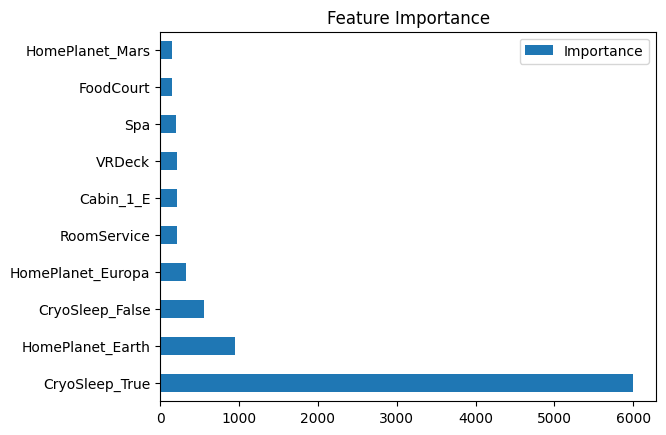

In [16]:
# Show the feature importances
feature_imp = pd.DataFrame(data=xgb_optimal.feature_importances_, index=xgb_optimal.feature_names_in_)
feature_imp.columns=['Importance']

feature_imp['Importance'] = feature_imp['Importance']*10000
feature_imp

feature_imp.nlargest(10, 'Importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [17]:
# Run on the X_test data
test_xgb_optimal_preds = xgb_optimal.predict(X_test)

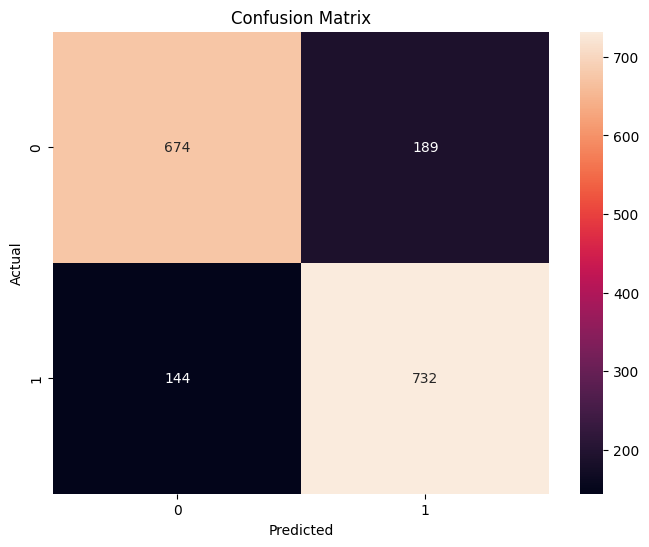

In [31]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_xgb_optimal_preds)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, test_xgb_optimal_preds)
precision = precision_score(y_test, test_xgb_optimal_preds)
recall = recall_score(y_test, test_xgb_optimal_preds)
f1 = f1_score(y_test, test_xgb_optimal_preds)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8085106382978723
Precision: 0.7947882736156352
Recall: 0.8356164383561644
F1 Score: 0.8146911519198664


In [28]:
# Visualize a tree with just 3 levels
from xgboost import plot_tree

xgb_3_levels = xgb.XGBClassifier(objective='binary:logistic', random_state=40, max_depth=3)
xgb_3_levels.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=40, ...)

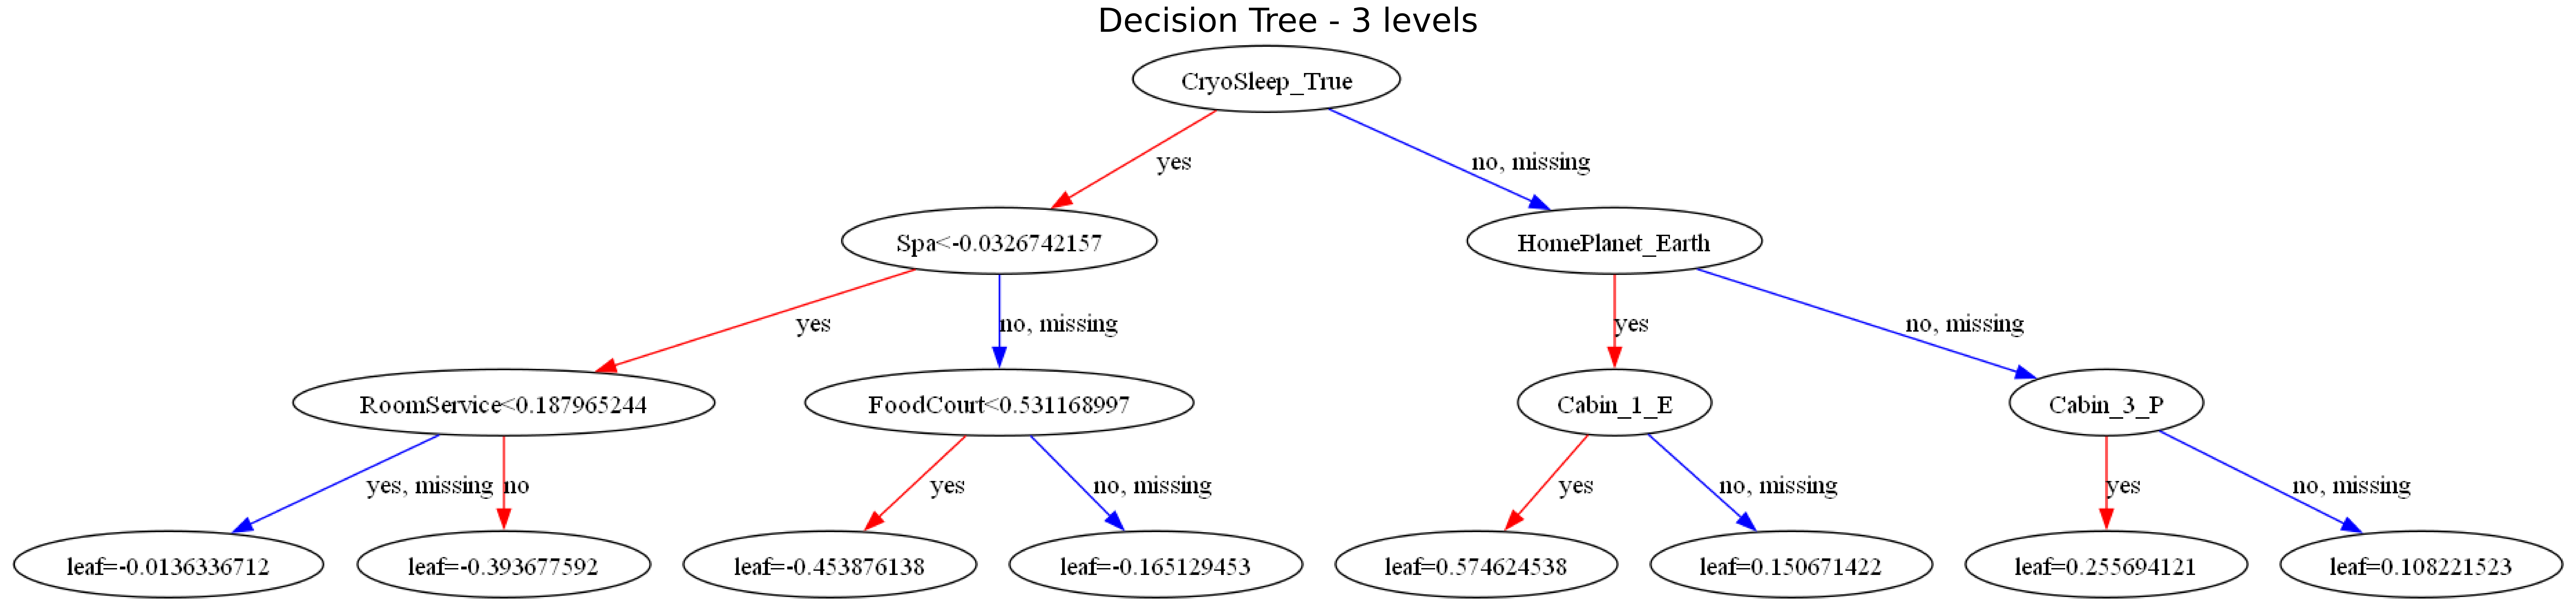

In [34]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(50,50), dpi=300)
xgb.plot_tree(xgb_3_levels, num_trees=0, ax=ax)
plt.title('Decision Tree - 3 levels', fontdict={'size':'36'})
plt.show()

# Use to predict on the test data

In [20]:
df_test_2 = feature_creation(df_test)

test_preds = xgb_optimal.predict(df_test_2)

In [21]:
df_test['Transported'] = test_preds.astype(bool)

In [22]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,True
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,False
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,True


In [23]:
# Submission needs to be the two columns
df_submission = df_test[['PassengerId', 'Transported']]

df_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


## Create submission for Kaggle

In [24]:
df_submission.to_csv('submission_2nd.csv', index=False)